In [1]:
#importing packages
library(lubridate)
library(dplyr)
library(tidyr)
library(ggplot2)
library(reshape2)
library(glmnet)


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date


Attaching package: 'dplyr'

The following objects are masked from 'package:lubridate':

    intersect, setdiff, union

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths

Loading required package: Matrix

Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand

Loading required package: foreach
Loaded glmnet 2.0-16



In [2]:
# importing data
realized_consumption=read.csv2(file = 'GercekZamanliTuketim.csv', sep=",",stringsAsFactors = F)

# Preprocessing

In [3]:
# initializing values
cons_start_date = "01.01.2016"
cons_test_start_date = "01.11.2019"
cons_end_date = "28.11.2019" # end date is selected as one day before homework submission
set.seed(2006703609)

In [4]:
# generating days in train and test period
itemizeDates <- function(startDate=startDate, endDate=endDate, 
                         format="%d.%m.%Y") 
{
  out <- seq(as.Date(startDate, format=format), 
             as.Date(endDate, format=format), by="days")  
  format(out, format)
}

valid_days = itemizeDates(startDate = cons_start_date, endDate = cons_end_date)

In [5]:
# checking if there are any NA values in data
any(is.na(realized_consumption[,3]))
# There are no NA values

[1] FALSE

In [6]:
# checking if there are realized consumption values for each valid days

missing_days = data.frame()

j = 1
for (i in valid_days)
{
    if(paste(i) %in% realized_consumption$Tarih == FALSE)
    {
        print(paste0("Consumption Value in Day ", paste(i), " is missing."))
        missing_days[j,"days"] = as.character(i)
        j = j + 1
    }
}



[1] "Consumption Value in Day 27.03.2016 is missing."


There is only one missing value. There are three options here. 
--> First 3 months can be discarded from the data and training is done on the remaining months (Can lead to major changes in the model, considerable number of data is discarded)
--> Code can be modified to overlook the data for 27.03.2016 (Complicated, does not add much to the model)
--> Missing 27.03.2016 value can be filled with realized consumption value of 168 hours ago (does not effect much on the model, easier to implement)
So the value is filled

In [7]:
# replacing missing date values with the 7 days prior values

# function for changing date format to char ( time YYYY-MM-DD --> char DD.MM.YYYY )
convert_time_to_char_. <- function(date) 
{
    prev_date_char = as.character(date)
    year = substr(date, 1, 4)
    month = substr(date, 6, 7)
    day = substr(date, 9, 10)
    prev_date_form = paste (day,month,year, sep = ".")
} 

# function for changing char format to date ( char DD.MM.YYYY --> time YYYY-MM-DD )
convert_date <- function(date, format_in, format_out) 
{
    temp_date <- strptime(as.character(date), format_in) 
    date = as.Date(format(temp_date, format_out))
}

# missing dates are added from 7 days ago
for(i in 1:nrow(missing_days))
{
    miss_date = convert_date(missing_days[i,"days"],"%d.%m.%Y","%Y-%m-%d")
    prev_date = miss_date - 7    
    prev_date_char = convert_time_to_char_.(prev_date)
    prev_cons=realized_consumption[realized_consumption$Tarih == prev_date_char,]
    miss_date_char = convert_time_to_char_.(miss_date)
    prev_cons[,"Tarih"] = miss_date_char   
#   realized consumption with missing values added, complete real consumption    
    cons = rbind(realized_consumption,prev_cons)
    print(head(cons))
    str(cons[1,"Tarih"])
}

       Tarih  Saat Tüketim.Miktarı..MWh.
1 01.01.2016 00:00             26.277,24
2 01.01.2016 01:00             24.991,82
3 01.01.2016 02:00             23.532,61
4 01.01.2016 03:00             22.464,78
5 01.01.2016 04:00             22.002,91
6 01.01.2016 05:00             21.957,08
 chr "01.01.2016"


In [8]:
# revising the data format and columns

# converting the date format
cons$Date = convert_date(cons$Tarih,"%d.%m.%Y","%Y-%m-%d")
# seperating hour
cons = separate(cons, Saat, into = c("Hour", "Minute"), sep = ":", remove = TRUE)
cons$Hour = as.numeric(cons$Hour) 
# making consumption as numeric
cons[,4]=as.numeric(gsub(",",".",gsub(".", "", cons[,4],fixed =T),fixed=T)) 
# finding weekday of the date
cons$Day <- wday(mdy(format(cons$Date, "%m-%d-%Y")), week_start = 1) 
# filling 48H and 168H Lag
cons['48HLag']=0
cons['168HLag']=0
cons=cons[order(cons$Date,cons$Hour, decreasing = F),] #sorting by Date and Hour
i=49
for(i in 49:nrow(cons))
{
    cons[i,7]=as.numeric(cons[i-48,4])
}
i=169
for(i in 169:nrow(cons))
{
    cons[i,8]=as.numeric(cons[i-168,4])
}
# removing unnecessary rows
cons = cons[,-3]
cons = cons[,-1]
head(cons)

Hour,Tüketim.Miktarı..MWh.,Date,Day,48HLag,168HLag
0,26277.24,2016-01-01,5,0,0
1,24991.82,2016-01-01,5,0,0
2,23532.61,2016-01-01,5,0,0
3,22464.78,2016-01-01,5,0,0
4,22002.91,2016-01-01,5,0,0
5,21957.08,2016-01-01,5,0,0


In [9]:
colnames(cons) = c("Hour", "Consumption","Date", "Day", "Lag48H", "Lag168H")
print(head(cons,100))

    Hour Consumption       Date Day   Lag48H Lag168H
1      0    26277.24 2016-01-01   5     0.00       0
2      1    24991.82 2016-01-01   5     0.00       0
3      2    23532.61 2016-01-01   5     0.00       0
4      3    22464.78 2016-01-01   5     0.00       0
5      4    22002.91 2016-01-01   5     0.00       0
6      5    21957.08 2016-01-01   5     0.00       0
7      6    22203.54 2016-01-01   5     0.00       0
8      7    21844.16 2016-01-01   5     0.00       0
9      8    23094.73 2016-01-01   5     0.00       0
10     9    25202.27 2016-01-01   5     0.00       0
11    10    27224.96 2016-01-01   5     0.00       0
12    11    28908.04 2016-01-01   5     0.00       0
13    12    28789.25 2016-01-01   5     0.00       0
14    13    29367.70 2016-01-01   5     0.00       0
15    14    29548.32 2016-01-01   5     0.00       0
16    15    29390.89 2016-01-01   5     0.00       0
17    16    30734.97 2016-01-01   5     0.00       0
18    17    32048.02 2016-01-01   5     0.00  

# Task a

In [10]:
# Creating test data
naive_test_cons = cons[cons$Date >= convert_date(cons_test_start_date,"%d.%m.%Y","%Y-%m-%d") & 
                       cons$Date <= convert_date(cons_end_date,"%d.%m.%Y","%Y-%m-%d"),]

print(naive_test_cons)
# Building Naive Forecast

# Calculating MAPE values
naive_test_cons$Mape_Lag48 = round((abs(naive_test_cons$Consumption - naive_test_cons$Lag48H) / naive_test_cons$Consumption * 100), 2)
naive_test_cons$Mape_Lag168 = round((abs(naive_test_cons$Consumption - naive_test_cons$Lag168H) / naive_test_cons$Consumption * 100), 2)


      Hour Consumption       Date Day   Lag48H  Lag168H
33577    0    29417.56 2019-11-01   5 27154.21 29563.43
33578    1    28133.75 2019-11-01   5 26157.42 28242.90
33579    2    27358.60 2019-11-01   5 25373.88 27258.74
33580    3    26780.09 2019-11-01   5 24911.43 26739.84
33581    4    26511.54 2019-11-01   5 24836.11 26555.35
33582    5    27002.74 2019-11-01   5 25233.76 26857.36
33583    6    27945.43 2019-11-01   5 26296.00 27783.77
33584    7    29120.27 2019-11-01   5 27575.60 28969.45
33585    8    32815.46 2019-11-01   5 31667.27 32153.21
33586    9    34569.09 2019-11-01   5 33138.17 33615.22
33587   10    35091.43 2019-11-01   5 32926.25 33398.50
33588   11    35416.33 2019-11-01   5 33122.35 33542.88
33589   12    33184.81 2019-11-01   5 31518.65 30839.72
33590   13    33549.94 2019-11-01   5 31895.21 30920.91
33591   14    35732.88 2019-11-01   5 33050.83 33019.99
33592   15    35859.75 2019-11-01   5 33464.69 33476.62
33593   16    36268.51 2019-11-01   5 34612.24 3

In [11]:
# Preparing the Table for MAPE Values of both Naive Models
model = c("Lag48", "Lag168")
MAPE = c(paste(round(mean(naive_test_cons$Mape_Lag48),2),"%"),paste(round(mean(naive_test_cons$Mape_Lag168),2),"%")) 
naive48_mape_result = round(mean(naive_test_cons$Mape_Lag48),2)
naive168_mape_result = round(mean(naive_test_cons$Mape_Lag168),2)
standard_dev = c(paste(round(sd(naive_test_cons$Mape_Lag48),2),"%"),paste(round(sd(naive_test_cons$Mape_Lag168),2),"%"))

naive_MAPE_table = data.frame(model, MAPE, standard_dev)
print(naive_MAPE_table)

   model   MAPE standard_dev
1  Lag48 7.71 %       8.38 %
2 Lag168 3.06 %       3.33 %


MAPE and Standard Deviation of Lag168 is much lower. That means, it explains variance better. So Lag168 is preferred.

# Task b

In [12]:
# Dividing the Data into Training and Test 

# Filling training data
# When Lag168 is used, no values could be populated for first 7 days. 
# So for the coefficients to not to be affected by it, they are removed 
lag_training_cons = cons[(cons$Date >= convert_date(cons_start_date,"%d.%m.%Y","%Y-%m-%d") + 7) & 
                          (cons$Date < convert_date(cons_test_start_date,"%d.%m.%Y","%Y-%m-%d")),]

# Selecting related columns
lag_training_cons = lag_training_cons %>% select(Date, Hour, Lag48H, Lag168H, Consumption)
head(lag_training_cons)

# Filling test data
lag_test_cons = cons[(cons$Date >= convert_date(cons_test_start_date,"%d.%m.%Y","%Y-%m-%d")) & 
                          (cons$Date < convert_date(cons_end_date,"%d.%m.%Y","%Y-%m-%d")),]

# Selecting related columns
lag_test_cons = lag_test_cons %>% select(Date, Hour, Lag48H, Lag168H, Consumption)
head(lag_test_cons)

# Getting all of the training and test together
lag_cons = rbind(lag_training_cons,lag_test_cons)
head(lag_cons)
nrow(lag_cons)

,Date,Hour,Lag48H,Lag168H,Consumption
169,2016-01-08,0,29189.27,26277.24,28602.02
170,2016-01-08,1,27614.02,24991.82,27112.37
171,2016-01-08,2,26578.97,23532.61,25975.34
172,2016-01-08,3,25719.19,22464.78,25315.55
173,2016-01-08,4,25864.63,22002.91,25128.15
174,2016-01-08,5,25918.59,21957.08,25356.22


,Date,Hour,Lag48H,Lag168H,Consumption
33577,2019-11-01,0,27154.21,29563.43,29417.56
33578,2019-11-01,1,26157.42,28242.90,28133.75
33579,2019-11-01,2,25373.88,27258.74,27358.60
33580,2019-11-01,3,24911.43,26739.84,26780.09
33581,2019-11-01,4,24836.11,26555.35,26511.54
33582,2019-11-01,5,25233.76,26857.36,27002.74


,Date,Hour,Lag48H,Lag168H,Consumption
169,2016-01-08,0,29189.27,26277.24,28602.02
170,2016-01-08,1,27614.02,24991.82,27112.37
171,2016-01-08,2,26578.97,23532.61,25975.34
172,2016-01-08,3,25719.19,22464.78,25315.55
173,2016-01-08,4,25864.63,22002.91,25128.15
174,2016-01-08,5,25918.59,21957.08,25356.22


[1] 34080

,Lag48H,Lag168H,Consumption
Lag48H,1.0000000,0.6533035,0.7337314
Lag168H,0.6533035,1.0000000,0.8387169
Consumption,0.7337314,0.8387169,1.0000000


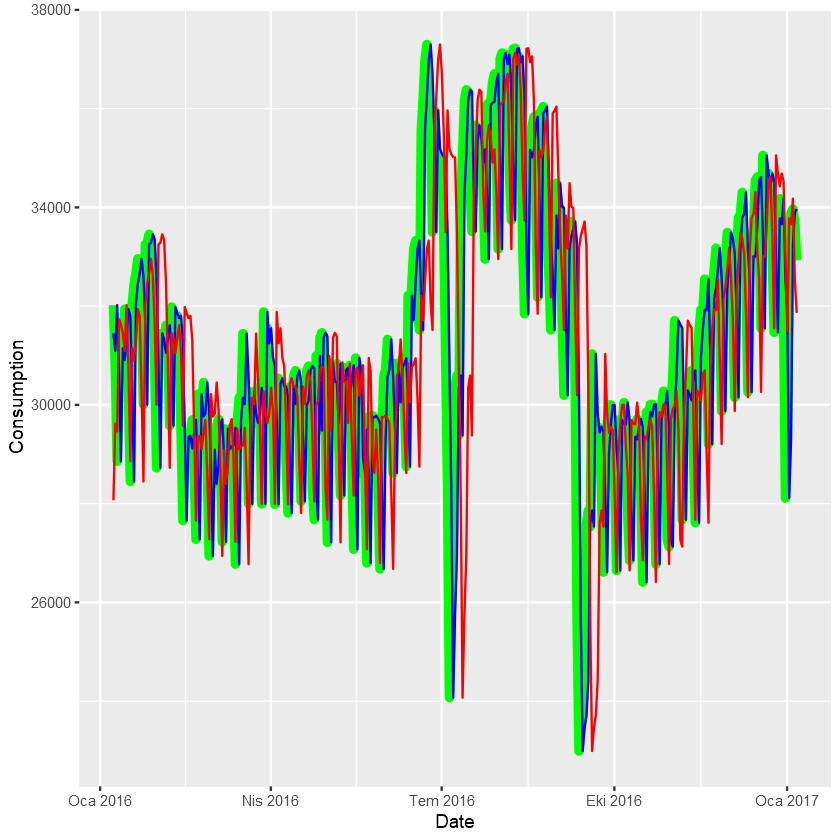

In [13]:
# Evaluating the training data
lag_training_cons$Date = as.POSIXct(lag_training_cons$Date)
ggplot() + 
  geom_line(data=lag_training_cons[1:365*24,], aes(Date, Consumption), color='green', size=2)+
  geom_line(data=lag_training_cons[1:365*24,], aes(Date, Lag48H), color='blue') +
  geom_line(data=lag_training_cons[1:365*24,], aes(Date, Lag168H), color='red') 
cor(lag_training_cons[,c(3:5)])

Correlation between Lag168 and Consumption is 0.8387169 which is higher. 

In [14]:
# Building Linear Model
linear_model = lm(Consumption ~ Lag48H + Lag168H , data=lag_training_cons) 

#Predicting values
lag_test_cons$Prediction = predict(linear_model, lag_test_cons, type="response")

In [15]:
# Calculating MAPE values
lag_test_cons$linear_mape = round((abs(lag_test_cons$Consumption - lag_test_cons$Prediction) / lag_test_cons$Consumption * 100), 2)

# Creating Summary Table
model = "Linear_Regression_Model"
MAPE = paste(round(mean(lag_test_cons$linear_mape),2),"%")
linear_mape_result = round(mean(lag_test_cons$linear_mape),2)
standard_dev = paste(round(sd(lag_test_cons$linear_mape),2),"%")
linear_MAPE_table = data.frame(model, MAPE, standard_dev)
print(linear_MAPE_table)
cat("\n")

linear_vs_naive = rbind(naive_MAPE_table, linear_MAPE_table)
print(linear_vs_naive)

                    model   MAPE standard_dev
1 Linear_Regression_Model 3.98 %       3.87 %

                    model   MAPE standard_dev
1                   Lag48 7.71 %       8.38 %
2                  Lag168 3.06 %       3.33 %
3 Linear_Regression_Model 3.98 %       3.87 %


MAPE and Standard Deviation of Lag168 is lowest of all. 
Why does not the linear model have less MAPE and Standard Dev? Because, it tries to reduce the MSE, which is a different measure. In that model absolute error margin for higher response values and lower response values are weighted the same. However in MAPE, for high response values, the model has more freedom to make errors.

# Task c

In [16]:
# Building linear regression models for each hour

linear_h_0 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 0))
linear_h_1 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 1))
linear_h_2 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 2))
linear_h_3 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 3))
linear_h_4 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 4))
linear_h_5 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 5))
linear_h_6 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 6))
linear_h_7 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 7))
linear_h_8 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 8))
linear_h_9 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 9))
linear_h_10 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 10))
linear_h_11 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 11))
linear_h_12 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 12))
linear_h_13 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 13))
linear_h_14 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 14))
linear_h_15 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 15))
linear_h_16 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 16))
linear_h_17 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 17))
linear_h_18 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 18))
linear_h_19 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 19))
linear_h_20 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 20))
linear_h_21 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 21))
linear_h_22 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 22))
linear_h_23 = lm(Consumption ~ Lag48H + Lag168H , data=filter(lag_training_cons, Hour == 23))

In [17]:
# Same training data as linear model in b is used
head(lag_test_cons)
linear_h_test = lag_test_cons[,c(1:5)]
head(linear_h_test)

,Date,Hour,Lag48H,Lag168H,Consumption,Prediction,linear_mape
33577,2019-11-01,0,27154.21,29563.43,29417.56,28933.70,1.64
33578,2019-11-01,1,26157.42,28242.90,28133.75,27783.28,1.25
33579,2019-11-01,2,25373.88,27258.74,27358.60,26912.72,1.63
33580,2019-11-01,3,24911.43,26739.84,26780.09,26437.73,1.28
33581,2019-11-01,4,24836.11,26555.35,26511.54,26297.73,0.81
33582,2019-11-01,5,25233.76,26857.36,27002.74,26615.83,1.43


,Date,Hour,Lag48H,Lag168H,Consumption
33577,2019-11-01,0,27154.21,29563.43,29417.56
33578,2019-11-01,1,26157.42,28242.90,28133.75
33579,2019-11-01,2,25373.88,27258.74,27358.60
33580,2019-11-01,3,24911.43,26739.84,26780.09
33581,2019-11-01,4,24836.11,26555.35,26511.54
33582,2019-11-01,5,25233.76,26857.36,27002.74


In [18]:
# Predicting Hourly Values
linear_h_test$Prediction = 0
linear_h_test[linear_h_test$Hour == 0,]$Prediction = predict(linear_h_0, linear_h_test[linear_h_test$Hour == 0,], type="response")
linear_h_test[linear_h_test$Hour == 1,]$Prediction = predict(linear_h_1, linear_h_test[linear_h_test$Hour == 1,], type="response")
linear_h_test[linear_h_test$Hour == 2,]$Prediction = predict(linear_h_2, linear_h_test[linear_h_test$Hour == 2,], type="response")
linear_h_test[linear_h_test$Hour == 3,]$Prediction = predict(linear_h_3, linear_h_test[linear_h_test$Hour == 3,], type="response")
linear_h_test[linear_h_test$Hour == 4,]$Prediction = predict(linear_h_4, linear_h_test[linear_h_test$Hour == 4,], type="response")
linear_h_test[linear_h_test$Hour == 5,]$Prediction = predict(linear_h_5, linear_h_test[linear_h_test$Hour == 5,], type="response")
linear_h_test[linear_h_test$Hour == 6,]$Prediction = predict(linear_h_6, linear_h_test[linear_h_test$Hour == 6,], type="response")
linear_h_test[linear_h_test$Hour == 7,]$Prediction = predict(linear_h_7, linear_h_test[linear_h_test$Hour == 7,], type="response")
linear_h_test[linear_h_test$Hour == 8,]$Prediction = predict(linear_h_8, linear_h_test[linear_h_test$Hour == 8,], type="response")
linear_h_test[linear_h_test$Hour == 9,]$Prediction = predict(linear_h_9, linear_h_test[linear_h_test$Hour == 9,], type="response")
linear_h_test[linear_h_test$Hour == 10,]$Prediction = predict(linear_h_10, linear_h_test[linear_h_test$Hour == 10,], type="response")
linear_h_test[linear_h_test$Hour == 11,]$Prediction = predict(linear_h_11, linear_h_test[linear_h_test$Hour == 11,], type="response")
linear_h_test[linear_h_test$Hour == 12,]$Prediction = predict(linear_h_12, linear_h_test[linear_h_test$Hour == 12,], type="response")
linear_h_test[linear_h_test$Hour == 13,]$Prediction = predict(linear_h_13, linear_h_test[linear_h_test$Hour == 13,], type="response")
linear_h_test[linear_h_test$Hour == 14,]$Prediction = predict(linear_h_14, linear_h_test[linear_h_test$Hour == 14,], type="response")
linear_h_test[linear_h_test$Hour == 15,]$Prediction = predict(linear_h_15, linear_h_test[linear_h_test$Hour == 15,], type="response")
linear_h_test[linear_h_test$Hour == 16,]$Prediction = predict(linear_h_16, linear_h_test[linear_h_test$Hour == 16,], type="response")
linear_h_test[linear_h_test$Hour == 17,]$Prediction = predict(linear_h_17, linear_h_test[linear_h_test$Hour == 17,], type="response")
linear_h_test[linear_h_test$Hour == 18,]$Prediction = predict(linear_h_18, linear_h_test[linear_h_test$Hour == 18,], type="response")
linear_h_test[linear_h_test$Hour == 19,]$Prediction = predict(linear_h_19, linear_h_test[linear_h_test$Hour == 19,], type="response")
linear_h_test[linear_h_test$Hour == 20,]$Prediction = predict(linear_h_20, linear_h_test[linear_h_test$Hour == 20,], type="response")
linear_h_test[linear_h_test$Hour == 21,]$Prediction = predict(linear_h_21, linear_h_test[linear_h_test$Hour == 21,], type="response")
linear_h_test[linear_h_test$Hour == 22,]$Prediction = predict(linear_h_22, linear_h_test[linear_h_test$Hour == 22,], type="response")
linear_h_test[linear_h_test$Hour == 23,]$Prediction = predict(linear_h_23, linear_h_test[linear_h_test$Hour == 23,], type="response")

In [19]:
# Calculating MAPE values
linear_h_test$hour_mape = round((abs(linear_h_test$Consumption - linear_h_test$Prediction) / linear_h_test$Consumption * 100), 2)

# Creating Summary Table
model = "Linear_Hourly_Regression"
MAPE = paste(round(mean(linear_h_test$hour_mape),2),"%")
linear_hourly_mape_result = round(mean(linear_h_test$hour_mape),2)
standard_dev = paste(round(sd(linear_h_test$hour_mape),2),"%")
linear_h_MAPE_table = data.frame(model, MAPE, standard_dev)
print(linear_h_MAPE_table)
cat("\n")

linear_vs_naive = rbind(naive_MAPE_table, linear_MAPE_table,linear_h_MAPE_table)
print(linear_vs_naive)

                     model  MAPE standard_dev
1 Linear_Hourly_Regression 4.1 %        3.5 %

                     model   MAPE standard_dev
1                    Lag48 7.71 %       8.38 %
2                   Lag168 3.06 %       3.33 %
3  Linear_Regression_Model 3.98 %       3.87 %
4 Linear_Hourly_Regression  4.1 %        3.5 %


MAPE and Standard Deviation of Lag168 is lowest of all again. Why does not the hourly linear model have less MAPE and Standard Dev? The same reason as in Task b

# Task d

In [20]:
# Filling Training Data Wide format for Lag48 and Lag168

# Getting Lag48 columns
lasso_cons_48 = lag_cons[,c(1,2,3)]
lasso_cons_48 = dcast(lasso_cons_48, Date ~ Hour, value.var = "Lag48H")
colnames(lasso_cons_48) = c("Date", c(paste("Lag_Day2_Hour_",c(0:23))))
# Getting Lag168 columns
lasso_cons_168 = lag_cons[,c(1,2,4)]
lasso_cons_168 = dcast(lasso_cons_168, Date ~ Hour, value.var = "Lag168H")
colnames(lasso_cons_168) = c("Date", c(paste("Lag_Day7_Hour_",c(0:23))))
# Joining Lag48 and Lag168 Columns
lasso_48_168 = left_join(lasso_cons_48, lasso_cons_168, by = "Date")
head(lasso_48_168)
# Getting Consumption Values
lasso_cons_val = lag_cons[,c(1,2,5)]
str(lasso_cons_val)
lasso_cons = dcast(lasso_cons_val, Date ~Hour, value.var="Consumption")
colnames(lasso_cons) = c("Date", c(paste("Consumption_",c(0:23))))
# Joining all
lasso_cons_all = left_join(lasso_48_168, lasso_cons, by = "Date")
head(lasso_cons_all)
nrow(lasso_cons_all)

Date,Lag_Day2_Hour_ 0,Lag_Day2_Hour_ 1,Lag_Day2_Hour_ 2,Lag_Day2_Hour_ 3,Lag_Day2_Hour_ 4,Lag_Day2_Hour_ 5,Lag_Day2_Hour_ 6,Lag_Day2_Hour_ 7,Lag_Day2_Hour_ 8,...,Lag_Day7_Hour_ 14,Lag_Day7_Hour_ 15,Lag_Day7_Hour_ 16,Lag_Day7_Hour_ 17,Lag_Day7_Hour_ 18,Lag_Day7_Hour_ 19,Lag_Day7_Hour_ 20,Lag_Day7_Hour_ 21,Lag_Day7_Hour_ 22,Lag_Day7_Hour_ 23
2016-01-08,29189.27,27614.02,26578.97,25719.19,25864.63,25918.59,27091.94,28533.05,33203.34,...,29548.32,29390.89,30734.97,32048.02,31438.11,30728.47,30166.14,29461.28,29242.83,28069.09
2016-01-09,28763.95,27284.84,26321.95,25748.49,25636.58,25932.52,26963.74,28444.83,32804.27,...,32796.18,32594.55,33358.47,34387.95,33591.26,32648.83,31897.73,31049.20,30906.43,29621.09
2016-01-10,28602.02,27112.37,25975.34,25315.55,25128.15,25356.22,26338.72,28086.42,32702.24,...,31056.47,30979.53,32297.46,33462.96,33151.03,32450.21,32093.93,31315.16,31014.19,29462.06
2016-01-11,29906.93,28061.98,26808.78,25798.80,25820.46,26035.77,26451.24,26853.42,30627.32,...,39661.98,39211.00,39760.12,39633.29,37621.41,35954.18,35114.12,34066.40,33686.83,31733.54
2016-01-12,28890.37,27133.75,25656.13,24937.87,24538.16,24616.05,24478.14,23813.35,24676.92,...,38086.11,37834.89,38599.34,38669.63,36954.78,35306.11,34301.59,33400.82,33359.37,31629.97
2016-01-13,27130.75,25403.40,24452.96,23959.85,23839.28,24358.46,25800.81,27336.03,32683.24,...,36847.22,36433.88,37581.09,37304.52,35832.00,34499.94,33670.00,32931.12,32913.06,31450.65


'data.frame':	34080 obs. of  3 variables:
 $ Date       : Date, format: "2016-01-08" "2016-01-08" ...
 $ Hour       : num  0 1 2 3 4 5 6 7 8 9 ...
 $ Consumption: num  28602 27112 25975 25316 25128 ...


Date,Lag_Day2_Hour_ 0,Lag_Day2_Hour_ 1,Lag_Day2_Hour_ 2,Lag_Day2_Hour_ 3,Lag_Day2_Hour_ 4,Lag_Day2_Hour_ 5,Lag_Day2_Hour_ 6,Lag_Day2_Hour_ 7,Lag_Day2_Hour_ 8,...,Consumption_ 14,Consumption_ 15,Consumption_ 16,Consumption_ 17,Consumption_ 18,Consumption_ 19,Consumption_ 20,Consumption_ 21,Consumption_ 22,Consumption_ 23
2016-01-08,29189.27,27614.02,26578.97,25719.19,25864.63,25918.59,27091.94,28533.05,33203.34,...,36555.58,36190.41,37031.72,37773.70,35930.69,34710.46,33907.65,33048.69,33220.16,32021.60
2016-01-09,28763.95,27284.84,26321.95,25748.49,25636.58,25932.52,26963.74,28444.83,32804.27,...,33524.80,32951.39,33655.89,35045.14,34407.27,33494.32,32624.31,32097.79,32176.63,30760.17
2016-01-10,28602.02,27112.37,25975.34,25315.55,25128.15,25356.22,26338.72,28086.42,32702.24,...,29089.83,29447.75,30569.07,32006.15,31706.26,31305.87,30870.26,30462.79,30537.75,28857.66
2016-01-11,29906.93,28061.98,26808.78,25798.80,25820.46,26035.77,26451.24,26853.42,30627.32,...,36383.06,36013.19,36848.54,37368.40,35697.30,34482.37,33526.95,32634.16,32791.35,31147.83
2016-01-12,28890.37,27133.75,25656.13,24937.87,24538.16,24616.05,24478.14,23813.35,24676.92,...,34934.00,34785.11,35690.28,36566.50,35055.97,33912.94,33131.98,32332.76,32523.14,30906.87
2016-01-13,27130.75,25403.40,24452.96,23959.85,23839.28,24358.46,25800.81,27336.03,32683.24,...,36201.35,36012.25,36785.82,37173.82,35574.06,34298.68,33580.53,32554.09,32836.52,31307.88


[1] 1420

In [21]:
#Data is divided into two parts as training and test data :
lasso_training_cons = lasso_cons_all[lasso_cons_all$Date < convert_date(cons_test_start_date,"%d.%m.%Y","%Y-%m-%d"),]
lasso_test_cons = lasso_cons_all[lasso_cons_all$Date >= convert_date(cons_test_start_date,"%d.%m.%Y","%Y-%m-%d"),]
nrow(lasso_training_cons)
nrow(lasso_test_cons)
head(lasso_training_cons)

[1] 1393

[1] 27

Date,Lag_Day2_Hour_ 0,Lag_Day2_Hour_ 1,Lag_Day2_Hour_ 2,Lag_Day2_Hour_ 3,Lag_Day2_Hour_ 4,Lag_Day2_Hour_ 5,Lag_Day2_Hour_ 6,Lag_Day2_Hour_ 7,Lag_Day2_Hour_ 8,...,Consumption_ 14,Consumption_ 15,Consumption_ 16,Consumption_ 17,Consumption_ 18,Consumption_ 19,Consumption_ 20,Consumption_ 21,Consumption_ 22,Consumption_ 23
2016-01-08,29189.27,27614.02,26578.97,25719.19,25864.63,25918.59,27091.94,28533.05,33203.34,...,36555.58,36190.41,37031.72,37773.70,35930.69,34710.46,33907.65,33048.69,33220.16,32021.60
2016-01-09,28763.95,27284.84,26321.95,25748.49,25636.58,25932.52,26963.74,28444.83,32804.27,...,33524.80,32951.39,33655.89,35045.14,34407.27,33494.32,32624.31,32097.79,32176.63,30760.17
2016-01-10,28602.02,27112.37,25975.34,25315.55,25128.15,25356.22,26338.72,28086.42,32702.24,...,29089.83,29447.75,30569.07,32006.15,31706.26,31305.87,30870.26,30462.79,30537.75,28857.66
2016-01-11,29906.93,28061.98,26808.78,25798.80,25820.46,26035.77,26451.24,26853.42,30627.32,...,36383.06,36013.19,36848.54,37368.40,35697.30,34482.37,33526.95,32634.16,32791.35,31147.83
2016-01-12,28890.37,27133.75,25656.13,24937.87,24538.16,24616.05,24478.14,23813.35,24676.92,...,34934.00,34785.11,35690.28,36566.50,35055.97,33912.94,33131.98,32332.76,32523.14,30906.87
2016-01-13,27130.75,25403.40,24452.96,23959.85,23839.28,24358.46,25800.81,27336.03,32683.24,...,36201.35,36012.25,36785.82,37173.82,35574.06,34298.68,33580.53,32554.09,32836.52,31307.88


In [22]:
# Constructing Lasso Regression models for each hour
# Applying 10 fold cross validation on 24 data folds
lasso_0 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,50], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_1 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,51], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_2 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,52], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_3 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,53], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_4 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,54], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_5 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,55], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_6 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,56], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_7 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,57], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_8 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,58], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_9 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,59], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_10 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,60], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_11 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,61], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_12 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,62], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_13 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,63], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_14 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,64], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_15 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,65], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_16 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,66], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_17 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,67], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_18 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,68], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_19 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,69], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_20 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,70], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_21 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,71], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_22 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,72], type.measure="mse", alpha=1, family="gaussian", nfolds=10)
lasso_23 <- cv.glmnet(as.matrix(lasso_training_cons[,c(2:49)]), lasso_training_cons[,73], type.measure="mse", alpha=1, family="gaussian", nfolds=10)

In [23]:
# Predicting Consumption Values for Each Model
lasso_test_cons$Prediction0 = predict(lasso_0, s=lasso_0$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction1 = predict(lasso_1, s=lasso_1$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction2 = predict(lasso_2, s=lasso_2$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction3 = predict(lasso_3, s=lasso_3$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction4 = predict(lasso_4, s=lasso_4$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction5 = predict(lasso_5, s=lasso_5$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction6 = predict(lasso_6, s=lasso_6$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction7 = predict(lasso_7, s=lasso_7$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction8 = predict(lasso_8, s=lasso_8$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction9 = predict(lasso_9, s=lasso_9$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction10 = predict(lasso_10, s=lasso_10$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction11 = predict(lasso_11, s=lasso_11$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction12 = predict(lasso_12, s=lasso_12$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction13 = predict(lasso_13, s=lasso_13$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction14 = predict(lasso_14, s=lasso_14$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction15 = predict(lasso_15, s=lasso_15$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction16 = predict(lasso_16, s=lasso_16$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction17 = predict(lasso_17, s=lasso_17$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction18 = predict(lasso_18, s=lasso_18$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction19 = predict(lasso_19, s=lasso_19$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction20 = predict(lasso_20, s=lasso_20$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction21 = predict(lasso_21, s=lasso_21$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction22 = predict(lasso_22, s=lasso_22$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))
lasso_test_cons$Prediction23 = predict(lasso_23, s=lasso_23$lambda.min, newx=as.matrix(lasso_test_cons[,c(2:49)]))

In [24]:
# Getting a new table, including only consumption and predicted values 
lasso_test_result = lasso_test_cons[,c(1,50:97)]
head(lasso_test_result)

,Date,Consumption_ 0,Consumption_ 1,Consumption_ 2,Consumption_ 3,Consumption_ 4,Consumption_ 5,Consumption_ 6,Consumption_ 7,Consumption_ 8,...,Prediction14,Prediction15,Prediction16,Prediction17,Prediction18,Prediction19,Prediction20,Prediction21,Prediction22,Prediction23
1394,2019-11-01,29417.56,28133.75,27358.60,26780.09,26511.54,27002.74,27945.43,29120.27,32815.46,...,34458.35,34799.48,35965.63,37459.01,37801.91,36871.28,35621.19,34618.78,33649.44,32141.87
1395,2019-11-02,29562.79,28256.30,27135.27,26480.50,26377.98,26551.33,26896.90,27288.43,29804.68,...,31238.86,31337.22,32086.19,33706.57,35331.17,34703.56,33657.35,32756.98,31724.80,30245.42
1396,2019-11-03,28453.56,26982.67,25789.05,25126.01,24921.85,24928.02,24992.22,24123.50,23869.05,...,28523.15,28821.49,29534.30,31156.16,33077.48,32905.48,32167.29,31232.87,30436.55,28991.87
1397,2019-11-04,27437.59,26099.72,25424.28,24896.77,24896.90,25330.16,26491.28,28166.73,31894.38,...,34720.89,34653.69,35516.88,36761.33,37297.20,36453.36,35401.55,34176.60,33408.16,31782.05
1398,2019-11-05,30282.48,28870.49,28060.26,27428.39,27219.83,27611.34,28607.40,29891.20,33332.65,...,33221.09,33406.47,34343.18,35986.36,37061.85,36223.75,35300.09,34339.92,33348.62,31746.78
1399,2019-11-06,30160.59,28729.17,27923.43,27371.76,27201.66,27616.48,28670.00,29957.97,32775.58,...,36641.26,36917.22,37996.25,39421.33,39664.87,38453.55,37281.73,36309.16,35212.14,33569.46


In [25]:
# Calculating MAPE values
lasso_test_result$mape_lasso_0 = round((abs(lasso_test_result[,2] - lasso_test_result[,26]) / lasso_test_result[,2] * 100), 2)
lasso_test_result$mape_lasso_1 = round((abs(lasso_test_result[,3] - lasso_test_result[,27]) / lasso_test_result[,3] * 100), 2)
lasso_test_result$mape_lasso_2 = round((abs(lasso_test_result[,4] - lasso_test_result[,28]) / lasso_test_result[,4] * 100), 2)
lasso_test_result$mape_lasso_3 = round((abs(lasso_test_result[,5] - lasso_test_result[,29]) / lasso_test_result[,5] * 100), 2)
lasso_test_result$mape_lasso_4 = round((abs(lasso_test_result[,6] - lasso_test_result[,30]) / lasso_test_result[,6] * 100), 2)
lasso_test_result$mape_lasso_5 = round((abs(lasso_test_result[,7] - lasso_test_result[,31]) / lasso_test_result[,7] * 100), 2)
lasso_test_result$mape_lasso_6 = round((abs(lasso_test_result[,8] - lasso_test_result[,32]) / lasso_test_result[,8] * 100), 2)
lasso_test_result$mape_lasso_7 = round((abs(lasso_test_result[,9] - lasso_test_result[,33]) / lasso_test_result[,9] * 100), 2)
lasso_test_result$mape_lasso_8 = round((abs(lasso_test_result[,10] - lasso_test_result[,34]) / lasso_test_result[,10] * 100), 2)
lasso_test_result$mape_lasso_9 = round((abs(lasso_test_result[,11] - lasso_test_result[,35]) / lasso_test_result[,11] * 100), 2)
lasso_test_result$mape_lasso_10 = round((abs(lasso_test_result[,12] - lasso_test_result[,36]) / lasso_test_result[,12] * 100), 2)
lasso_test_result$mape_lasso_11 = round((abs(lasso_test_result[,13] - lasso_test_result[,37]) / lasso_test_result[,13] * 100), 2)
lasso_test_result$mape_lasso_12 = round((abs(lasso_test_result[,14] - lasso_test_result[,38]) / lasso_test_result[,14] * 100), 2)
lasso_test_result$mape_lasso_13 = round((abs(lasso_test_result[,15] - lasso_test_result[,39]) / lasso_test_result[,15] * 100), 2)
lasso_test_result$mape_lasso_14 = round((abs(lasso_test_result[,16] - lasso_test_result[,40]) / lasso_test_result[,16] * 100), 2)
lasso_test_result$mape_lasso_15 = round((abs(lasso_test_result[,17] - lasso_test_result[,41]) / lasso_test_result[,17] * 100), 2)
lasso_test_result$mape_lasso_16 = round((abs(lasso_test_result[,18] - lasso_test_result[,42]) / lasso_test_result[,18] * 100), 2)
lasso_test_result$mape_lasso_17 = round((abs(lasso_test_result[,19] - lasso_test_result[,43]) / lasso_test_result[,19] * 100), 2)
lasso_test_result$mape_lasso_18 = round((abs(lasso_test_result[,20] - lasso_test_result[,44]) / lasso_test_result[,20] * 100), 2)
lasso_test_result$mape_lasso_19 = round((abs(lasso_test_result[,21] - lasso_test_result[,45]) / lasso_test_result[,21] * 100), 2)
lasso_test_result$mape_lasso_20 = round((abs(lasso_test_result[,22] - lasso_test_result[,46]) / lasso_test_result[,22] * 100), 2)
lasso_test_result$mape_lasso_21 = round((abs(lasso_test_result[,23] - lasso_test_result[,47]) / lasso_test_result[,23] * 100), 2)
lasso_test_result$mape_lasso_22 = round((abs(lasso_test_result[,24] - lasso_test_result[,48]) / lasso_test_result[,24] * 100), 2)
lasso_test_result$mape_lasso_23 = round((abs(lasso_test_result[,25] - lasso_test_result[,49]) / lasso_test_result[,25] * 100), 2)

In [26]:
# Calculating MAPE values
lasso_mape_data = data.frame(lasso_test_result$mape_lasso_0, lasso_test_result$mape_lasso_1, lasso_test_result$mape_lasso_2,lasso_test_result$mape_lasso_3,
          lasso_test_result$mape_lasso_4, lasso_test_result$mape_lasso_5, lasso_test_result$mape_lasso_6, lasso_test_result$mape_lasso_7,
          lasso_test_result$mape_lasso_8, lasso_test_result$mape_lasso_9, lasso_test_result$mape_lasso_10, lasso_test_result$mape_lasso_11,
          lasso_test_result$mape_lasso_12, lasso_test_result$mape_lasso_13, lasso_test_result$mape_lasso_14, lasso_test_result$mape_lasso_15,
          lasso_test_result$mape_lasso_16, lasso_test_result$mape_lasso_17, lasso_test_result$mape_lasso_18, lasso_test_result$mape_lasso_19,
          lasso_test_result$mape_lasso_20, lasso_test_result$mape_lasso_21, lasso_test_result$mape_lasso_22, lasso_test_result$mape_lasso_23)
lasso_mape_data = t(lasso_mape_data)
lasso_mape_data = c(lasso_mape_data[,1],lasso_mape_data[,2],lasso_mape_data[,3],lasso_mape_data[,4],lasso_mape_data[,5],
                lasso_mape_data[,6],lasso_mape_data[,7],lasso_mape_data[,8],lasso_mape_data[,9],lasso_mape_data[,10])
print(lasso_mape_data)

   X1  X1.1  X1.2  X1.3  X1.4  X1.5  X1.6  X1.7  X1.8  X1.9 X1.10 X1.11 X1.12 
 1.93  1.68  1.66  1.68  2.11  1.50  1.72  2.25  1.77  0.99  1.02  1.84  2.10 
X1.13 X1.14 X1.15 X1.16 X1.17 X1.18 X1.19 X1.20 X1.21 X1.22 X1.23    X1  X1.1 
 3.44  3.57  2.96  0.84  1.21  1.62  2.26  1.40  1.98  2.35  1.74  0.16  0.07 
 X1.2  X1.3  X1.4  X1.5  X1.6  X1.7  X1.8  X1.9 X1.10 X1.11 X1.12 X1.13 X1.14 
 0.51  0.59  0.18  0.15  0.32  0.41  0.39  0.71  0.59  0.41  0.61  0.58  1.71 
X1.15 X1.16 X1.17 X1.18 X1.19 X1.20 X1.21 X1.22 X1.23    X1  X1.1  X1.2  X1.3 
 2.05  1.75  1.37  0.94  0.16  0.37  0.39  0.11  0.42  1.10  1.57  2.20  2.04 
 X1.4  X1.5  X1.6  X1.7  X1.8  X1.9 X1.10 X1.11 X1.12 X1.13 X1.14 X1.15 X1.16 
 1.71  2.11  2.32  4.09  8.27  9.82 10.40 11.29 10.05 10.52 11.48 10.16  7.52 
X1.17 X1.18 X1.19 X1.20 X1.21 X1.22 X1.23    X1  X1.1  X1.2  X1.3  X1.4  X1.5 
 4.11  1.45  0.62  0.26  0.73  0.00  0.22  3.82  3.49  3.00  3.00  2.54  2.15 
 X1.6  X1.7  X1.8  X1.9 X1.10 X1.11 X1.12 X1.13 X1.1

In [27]:
# Creating Summary Table
model = "Lasso Regression"
MAPE = paste(round(mean(lasso_mape_data),2),"%")
lasso_mape_result = round(mean(lasso_mape_data),2)
standard_dev = paste(round(sd(lasso_mape_data),2),"%")
lasso_MAPE_table = data.frame(model, MAPE, standard_dev)
print(lasso_MAPE_table)
cat("\n")

lasso_linear_naive = rbind(naive_MAPE_table, linear_MAPE_table,linear_h_MAPE_table, lasso_MAPE_table)
print((lasso_linear_naive))

             model   MAPE standard_dev
1 Lasso Regression 2.73 %       2.65 %

                     model   MAPE standard_dev
1                    Lag48 7.71 %       8.38 %
2                   Lag168 3.06 %       3.33 %
3  Linear_Regression_Model 3.98 %       3.87 %
4 Linear_Hourly_Regression  4.1 %        3.5 %
5         Lasso Regression 2.73 %       2.65 %


When Lasso Regression is intruduced, with MAPE value of 2.71 and standard deviation of 2.64 performs best. This is expected, as consecutive coefficient differences are penalized. Lasso is expected to have better results than others. It is as expected.

In [28]:
# Displaying Lasso Regression coefficients for each hour
coefficients_lasso = cbind(coefficients(lasso_0), coefficients(lasso_1),coefficients(lasso_2),coefficients(lasso_3),
                           coefficients(lasso_4),coefficients(lasso_5),coefficients(lasso_6),coefficients(lasso_7),
                           coefficients(lasso_8),coefficients(lasso_9),coefficients(lasso_10),coefficients(lasso_11),
                           coefficients(lasso_12),coefficients(lasso_13),coefficients(lasso_14),coefficients(lasso_15),
                           coefficients(lasso_16),coefficients(lasso_17),coefficients(lasso_18),coefficients(lasso_19),
                           coefficients(lasso_20),coefficients(lasso_21),coefficients(lasso_22),coefficients(lasso_23))
colnames(coefficients_lasso) = c(paste("Lasso_Hour_",0:23))
coefficients_lasso

   [[ suppressing 24 column names 'Lasso_Hour_ 0', 'Lasso_Hour_ 1', 'Lasso_Hour_ 2' ... ]]


49 x 24 sparse Matrix of class "dgCMatrix"
                                                                         
(Intercept)       1317.83736047 1887.96842715 2085.13903345  1.913878e+03
Lag_Day2_Hour_ 0    -0.09715343   -0.18346217   -0.33109135 -3.864382e-01
Lag_Day2_Hour_ 1    -0.03210391    .             .           .           
Lag_Day2_Hour_ 2     .             .             .           .           
Lag_Day2_Hour_ 3     .             .             0.08742721  .           
Lag_Day2_Hour_ 4     .             0.08092450    0.20324175  3.506982e-01
Lag_Day2_Hour_ 5     .             .             .           .           
Lag_Day2_Hour_ 6     .             .             .           .           
Lag_Day2_Hour_ 7     0.09258934    0.08380297    .           .           
Lag_Day2_Hour_ 8     .             .             .           .           
Lag_Day2_Hour_ 9    -0.52276561   -0.32687962   -0.32277725 -3.547502e-01
Lag_Day2_Hour_ 10   -0.05269939   -0.30157646   -0.26776659 -2.213175

Although Lasso Tends to Zero out Coefficients generally, in this case it cannot zero out the coefficients. There are lots of nonzero coefficients even though it is penalized. 

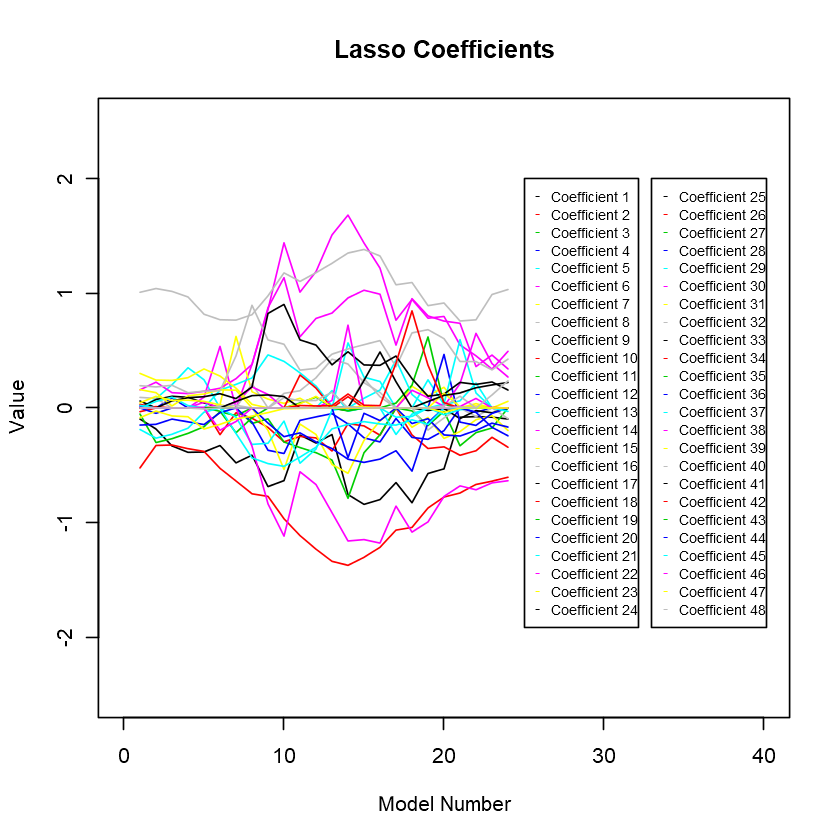

In [29]:
plot(coefficients_lasso[2,],type="l",col=1,xlim = c(0,40),ylim = c(-2.5,2.5),main="Lasso Coefficients", xlab="Model Number",
     ylab="Value")
for (i in 3:nrow(coefficients_lasso)) {
    points(coefficients_lasso[i,],type="l",col=(i-1))
}

names = c()
cum_names = c()
for (i in 1:24) {
    names = paste("Coefficient", i)
    cum_names = c(cum_names, names)
}
par(xpd=TRUE)
legend(25,2,cex = 0.7,
legend = cum_names, 
        col = c(1:23), pch = "-")
names = c()
cum_names = c()
for (i in 25:48) {
    names = paste("Coefficient", i)
    cum_names = c(cum_names, names)
}
par(xpd=TRUE)
legend(33,2,cex = 0.7,
legend = cum_names, 
        col = c(25:48), pch = "-")

Coefficients can be seen as above. 
There are 24 seperate models with cross validation.
Each line displayes lasso coefficient for each feature for each model.

# Task f

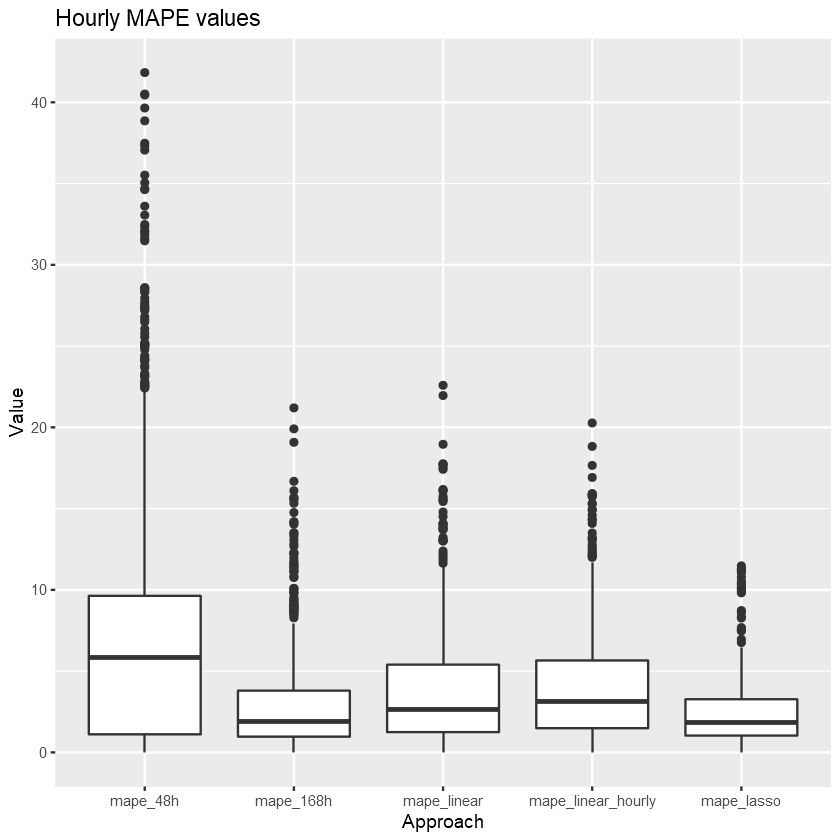

In [30]:
# Collecting all MAPE Values in a Diagram
df1=data.frame(value=naive_test_cons$Mape_Lag48,group="mape_48h")
df2=data.frame(value=naive_test_cons$Mape_Lag168,group="mape_168h")
df3=data.frame(value=lag_test_cons$linear_mape,group="mape_linear")
df4=data.frame(value=linear_h_test$hour_mape,group="mape_linear_hourly")
df5=data.frame(value=lasso_mape_data,group="mape_lasso")
df=rbind(df1,df2,df3,df4,df5)
ggplot(df, aes(factor(group), value)) + geom_boxplot() + labs( title = "Hourly MAPE values",x="Approach",y="Value")

All of the models have some of the data explained. there is no inconsistancy. 

Considering all the models, predictions of mape_lasso are most accurate. Also median of mape_lasso seems to be lowest of all. Also lasso has a narrower prediction interval and has less values outside of the confidence interval. When compared to other models, it seems most reliable. It is the best alternative.

On the other hand, Lag 48 has the highest median, has the widest confidence interval, and has lots of data points outside of the prediction interval. It is the worst alternative.

[1] 7.71
[1] 3.06
[1] 3.98
[1] 4.1
[1] 2.73


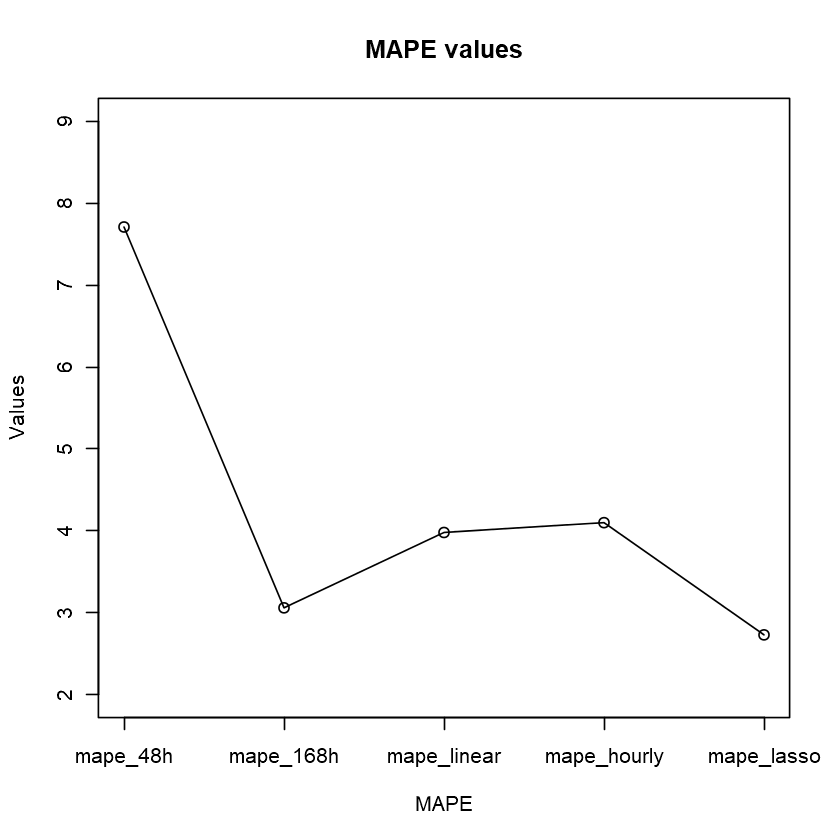

In [31]:
plot(xaxt="n",ylim=c(2,9),
     c(naive48_mape_result ,naive168_mape_result, linear_mape_result, linear_hourly_mape_result, lasso_mape_result),
     type="o",main="MAPE values",xlab="MAPE",ylab="Values")
axis(1,at=seq_along(c(naive48_mape_result ,naive168_mape_result ,
       linear_mape_result ,linear_hourly_mape_result ,lasso_mape_result)),
     labels = c("mape_48h","mape_168h","mape_linear","mape_hourly","mape_lasso"))
print(naive48_mape_result)
print(naive168_mape_result )
print(linear_mape_result )
print(linear_hourly_mape_result )
print(lasso_mape_result )

# Conclusion

With compared MAPE values, Lasso Regression model seems to work best. It has 2,73 MAPE, which is the lowest. This is logical, because Lasso tries to minimize and zero out unnecessary coefficients. Also it tries to penalize difference between consecutive coefficients. Makes it suitable for time series analysis. 

Second best is the 168 hour lag, with 3,06 MAPE which shows the trend somehow.